## **Assignment 3: Discrete Event Simulation**



## **Setup**





**Please log into your Stanford Google Drive account when viewing this notebook.** Log in using your SUNetID credentials.

Before we can start Assignment 3, we need to go through a few minor tasks, as we did in Assignment 1:
1. Copy Google Colab Notebook (File > Save a copy in Drive)
2. Connect to Github Data Repo
3. Set Up Working Directory

The detailed instructions for the above tasks were provided in Assignment 1, so we don't need to go through them again here. If you need assistance with any of the above tasks, please refer to Assignment 1. We'll simply implement tasks 2 and 3 in the code cell below.

In [1]:
# Connect to Github Data Repo
!git clone https://github.com/verma-aniket/CEE_266G_Data_Repo GitRepo

# Set up working directory
import os
wdir = 'GitRepo/Data'
os.chdir(wdir)

Cloning into 'GitRepo'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 46 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 1.03 MiB | 4.62 MiB/s, done.
Resolving deltas: 100% (9/9), done.


*** Please remember to save a copy of this Google Colab notebook to your drive so that you can edit it.**

Once the above code cell is finished running, you are ready to start Assignment 3!

## **Assignment 3**

**You are encouraged to discuss the problems with your group and with the teaching team. You may not collaborate with students outside your group.  The final code and write up you submit must be your own.**

This assignment contains incomplete Python code that you will complete, as well as some write ups. Please feel free to add text or coding cells as you see fit. There are two problems for you to complete.

In the code snippet below, we will import the required libraries for Problems 1 and 2.

In [2]:
# Import Libraries for Problem 1 and 2: Numpy, Matplotlib, and Pandas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# **Problem 1**: Reservoir simulation

In class, we demonstrated an example of a simple reservoir model that calculates the reliability of supply at the monthly time scale in Lake Oroville. For your assignment, you will extend that reservoir model to measure the performance of the reservoir against multiple performance objectives, and apply it at the daily time scale in Shasta Lake. You will use the historical unimpaired flow data in "SHA_daily.csv". The units in the file are: Storage (TAF), Elevation (ft), Outflow (TAF), Inflow (TAF), Evaporation (TAF).

In the below code snippet, we will read Shasta Lake inflow data (which is saved in the 'SHA_daily.csv' file). Go ahead and run the code cell!

In [3]:
# Load data
data = pd.read_csv('SHA_daily.csv', delimiter=',', usecols=[4])
data = data.fillna(method='ffill') # fill in missing values using previous value
print(data)

# Reservoir/demand parameters and assumptions
K = 4552 # Shasta Reservoir Capacity (TAF)
D = 12.5 # Daily demand (TAF/d)


         inflow
0      6.470083
1      7.523306
2      8.800661
3      7.281322
4      9.720992
...         ...
6316   9.851901
6317  10.601653
6318  13.896198
6319  10.839669
6320  11.111405

[6321 rows x 1 columns]


<ipython-input-3-4be4a3bd9174>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill') # fill in missing values using previous value


*Please note: we have defined the downstream water elevation (assumed constant, ignoring hydraulic effects), turbine max outflow, and turbine efficiency, as well as a function called "storage_to_elevation" that provides the storage elevation relationship in the code cell below. This code will be useful in Part C on hydropower.

In [4]:
# cubic feet per second to thousand acre-foot perday conversion
cfs_to_taf = 2.29568411*10**-5 * 86400 / 1000

# define stage-storage function
def storage_to_elevation(S): # from regression
  # Takes storage in TAF and returns elevation in feet
  return -6.017e-06*S**2 + 0.0821*S + 815.9728

# define hydropower parameters
downstream_wse = 134 # feet
turbine_max_outflow = 8600 # cubic feet per second
efficiency = 0.82

You will now complete the rest of Problem 1. Code cells containing commented instructions are provided for you below.

*Part A:* The capacity of the reservoir is 4552 TAF. Assume the daily demand is 12.5 TAF. Write a function called "simulate_shasta" that takes inflow data as an input, simulates daily reservoir operations using the same simple operating rule as in the Lake Oroville example, and reports the reliability, defined as the percentage of days in which demand was fully met. Report the reliability. You are welcome to use the [code from the Week 3 in-class tutorial](https://colab.research.google.com/drive/1iOi_EzMuIoBJaMbhavqrQ-h7Thr-9AGu?usp=sharing) as a starting point.

In [5]:
# define simulate_shasta_A function

def simulate_shasta_A(Q):

  # Length of time series
  T = len(Q)

  # Initialize state vectors
  S = np.zeros(T) # storage
  R = np.zeros(T) # release

  # Setting the initial condition
  S[0] = K
  R[0] = D

  for t in range(1,T):

    # new storage: mass balance, max value is K
    S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)

    # release is based on demand
    if S[t] + Q[t] > D:
      R[t] = D
    else:
      R[t] = S[t] + Q[t]

  reliability = R[R==D].size / float(T)

  return reliability, R, S, T

# Apply the function to the Oroville data
Q = data['inflow'].values
[rel, R, S, T] = simulate_shasta_A(Q)
print(rel)


0.9900332225913622


In [6]:
# Report Reliability
print("The Reliability is", rel)

The Reliability is 0.9900332225913622


*Part B:* Next, keeping the operations the same, adapt your "simulate_shasta" function above to add a spill variable to keep track of the amount of flow you release downstream. Add a new performance objective called "alteration" that quantifies the difference between the altered flow downstream of the reservoir and the unimpaired flow. Quantify this as: the sum over the full time period of the absolute value of the difference between the altered and unimpaired daily flow values, expressed as a percentage of the sum of the total unimpaired flow values. Run the model and report the alteration metric.

In [7]:
# define simulate_shasta_B function
#    - update simulate_shasta_B function by adding alteration calculation

def simulate_shasta_B(Q):


  # Length of time series
  T = len(Q)

  # Initialize state vectors
  S = np.zeros(T) # storage
  R = np.zeros(T) # release
  A = np.zeros(T) #alternation
  spill = np.zeros(T) #spill

  # Setting the initial condition
  S[0] = K
  R[0] = D

  for t in range(1,T):
    # new storage: mass balance, max value is K
    S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)
    # Check if there is a spill
    if S[t-1] + Q[t-1] - R[t-1] > K:
      spill[t] = S[t-1] + Q[t-1] - R[t-1] - K
    else:
      spill[t] = 0

    # release is based on demand
    if S[t] + Q[t] > D:
      R[t] = D
    else:
      R[t] = S[t] + Q[t]
    A[t] = np.abs(spill[t] - Q[t])

  alternation = np.sum(A) / np.sum(Q) * 100
  reliability = R[R==D].size / float(T)

  return reliability, R, S, T, alternation, spill

# Apply the function to the Oroville data
Q = data['inflow'].values
[rel, R, S, T, alt, spill] = simulate_shasta_B(Q)
print(alt)


85.45584512273746


In [8]:
# Report Alteration
print("The alteration is", alt)

The alteration is 85.45584512273746


*Part C*: Next, keeping the operations the same, add a performance metric quantifying the daily hydropower generated to your "simulate_shasta" function. Please remember to use the hydropower parameters and the stage-storage function provided at the beginning of this question.

Assume that both the release to demand and as much of the spill as possible go through the penstock and therefore lead to hydropower generation. This means that "spill" refers to the total amount of flow downstream.

Run the model and report the hydropower generation in MW by plotting the timeseries. What patterns do you notice in the hydropower generation time series? Note anything you think is unrealistic compared to actual practice and explain why it occurs in our model.

In [9]:
# define simulate_shasta_C function
#    - update simulate_shasta_C function by adding hydropower calculation

# define simulate_shasta_B function
#    - update simulate_shasta_B function by adding alteration calculation

def simulate_shasta_C(Q):

  rho = 62.4 #lb/ft3
  g = 32 #/sec2

  # Length of time series
  T = len(Q)

  # Initialize state vectors
  S = np.zeros(T) # storage
  R = np.zeros(T) # release
  A = np.zeros(T) # alternation
  spill = np.zeros(T) # spill
  hydro = np.zeros(T) # hydropower

  # Setting the initial condition
  S[0] = K
  R[0] = D

  for t in range(1,T):
    # new storage: mass balance, max value is K
    S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)
    # Check if there is a spill
    if S[t-1] + Q[t-1] - R[t-1] > K:
      spill[t] = S[t-1] + Q[t-1] - R[t-1] - K
    else:
      spill[t] = 0

    # release is based on demand
    if S[t] + Q[t] > D:
      R[t] = D
    else:
      R[t] = S[t] + Q[t]
    A[t] = np.abs(R[t] - Q[t])

  #hydropower calc P = η⋅ρ⋅g⋅H⋅Q
    head = (storage_to_elevation(S[t]) - downstream_wse) #ft
    q = (min(turbine_max_outflow, (R[t] + spill[t])/cfs_to_taf)) #cfs
    hydro[t] = efficiency * rho * g * head * q * 1.36 * (10 ** (-6))

  alternation = np.sum(A) / np.sum(Q) * 100
  reliability = R[R==D].size / float(T)


  return reliability, R, S, T, alternation, spill, hydro

# Apply the function to the Oroville data
Q = data['inflow'].values
[rel, R, S, T, alt, spill, hydro] = simulate_shasta_C(Q)

hydro

array([    0.        , 13063.25593692, 13061.3406267 , ...,
       12666.62880878, 12667.36975668, 12666.48859951])

Text(0, 0.5, 'Hydropower (MW)')

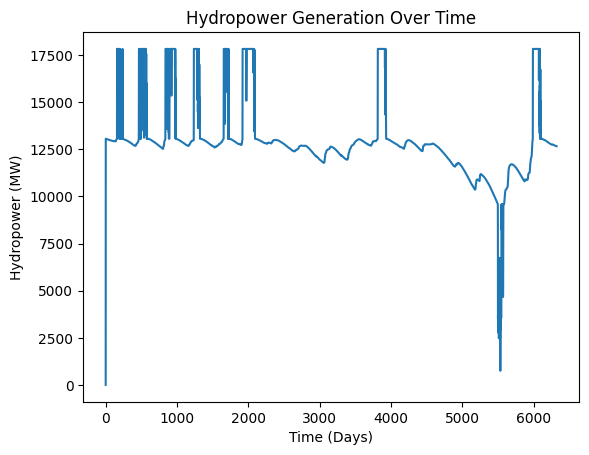

In [10]:
plt.plot(hydro, label='Hydropower Generation (MW)')

# Add title and labels
plt.title('Hydropower Generation Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Hydropower (MW)')

Initial High Variability: The early period shows frequent sharp spikes and drops in generation. This could be indicative of extreme variations in flow conditions, likely caused by the release patterns in the model

Overall Stability: For much of the time series, hydropower generation appears to be relatively stable, hovering around 10,000 to 12,000 MW, which suggests that the reservoir level is being managed well enough to keep the turbines operating near their maximum capacity for extended periods.

Dips in Generation: There are some significant drops, especially a sharp decline around day 5,800. This could be a sign of lower reservoir levels during that period, possibly caused by insufficient inflow or higher demands, which restrict the ability to release water through the turbines.

Quick Recovery: After the sharp drop in power generation, the system quickly recovers, which suggests that inflow likely increased again, refilling the reservoir and enabling turbine flow to return to normal.

Instant recovery ffter dip is unrealistic: This quick recovery may be a result of the model’s relatively simple logic for handling reservoir storage, where changes are computed based on instantaneous inflow and outflow. If inflow increases dramatically, the storage is quickly replenished, leading to an immediate increase in hydropower production, whereas in practice, storage recovery could take days or weeks.

*Part D:* Now you will test how your reservoir performs under different streamflow conditions.


*   First, make a new inflow timeseries called "dry_flow": create it by multiplying the historical record by 0.8, so that the streamflow has the same historical pattern, but scaled down by 20%.
*   Second, make another new inflow timeseries called "variable_flow". Create it by calculating the daily anomalies from the mean historical flow, multiplying the anomalies by 1.2, and then adding back the historical flow. (Anomalies are the difference between the time series and the mean of the time series.) The "variable_flow" timeseries should have the same mean flow value greater variability.
*    Third, make a plot with the historical streamflow, dry flow, and variable flow to show how they compare.
*    Finally, simulate your reservoir under the new streamflow scenarios and report the performance against your three objectives. How does the performance change and why?



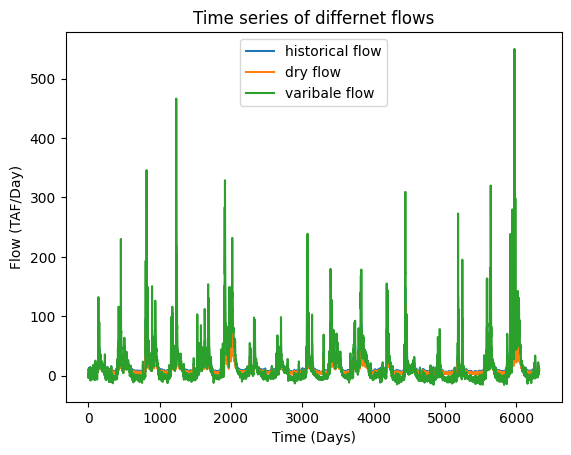

In [11]:
# Create dry_flow
dry_flow = 0.8 * Q
variable_flow = np.zeros(len(Q))

# Create variable_flow (correction for negative flows embedded)
mean = np.mean(Q)
for i in range(len(Q)):
  variable_flow[i] = (Q[i] - mean) * 1.2 +Q[i]

# Plot historical, dry, and variable flow
plt.plot(Q, label = "historical flow")
plt.plot(dry_flow, label = "dry flow")
plt.plot(variable_flow, label = "varibale flow")

plt.title('Time series of differnet flows')
plt.xlabel('Time (Days)')
plt.ylabel('Flow (TAF/Day)')
plt.legend()


Reliability for historical_records: 0.9900332225913622
Alternation for historical_records: 58.38439927843394
Reliability for dry_flow: 0.8664768232874546
Alternation for dry_flow: 58.06394925506642
Reliability for variable_flow: 0.8762853978800823
Alternation for variable_flow: 120.31745045843951


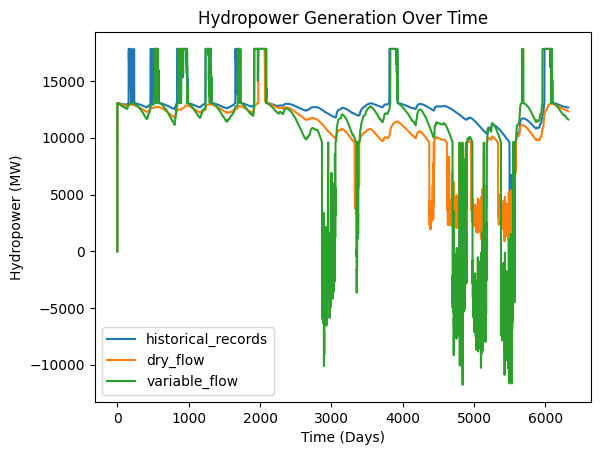

In [12]:
# Simulate reservoir under new streamflow scenarios

flow = [Q, dry_flow, variable_flow]
flow_title = ["historical_records", "dry_flow", "variable_flow"]

for i in range(len(flow)):
  [rel, R, S, T, alt, spill, hydro] = simulate_shasta_C(flow[i])
  print(f"Reliability for {flow_title[i]}: {rel}")
  print(f"Alternation for {flow_title[i]}: {alt}")
  plt.plot(hydro, label = flow_title[i])
  # Add title and labels
  plt.title(f'Hydropower Generation Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Hydropower (MW)')
plt.legend()

Type your answer to part D here:
1. Reliability:
Historical Flow: The reliability is very high (0.99), meaning the reservoir can meet demand nearly all the time under historical inflow conditions.
Dry Flow: The reliability drops to around 0.87. This is expected because a 20% reduction in inflow makes it harder for the reservoir to meet the demand consistently.
Variable Flow: The reliability further decreases to 0.87, indicating that the increased variability in streamflow causes more frequent shortages, despite having the same mean inflow.
2. Alternation:
Historical Flow: Alternation is around 58%, which is a measure of how much the releases differ from the inflows.
Dry Flow: Alternation remains similar to the historical value, around 58%, suggesting that the demand is still met relatively consistently, but at a reduced scale.
Variable Flow: Alternation increases significantly (120%), indicating that the reservoir has to release flows that differ much more from the inflows in this scenario. The higher variability in inflow makes managing the reservoir more challenging, requiring more adjustment to maintain operations.
3. Hydropower:
Hydropower Output: The plot shows that under the variable flow scenario, hydropower generation experiences much more frequent and significant dips, sometimes even going negative, which suggests turbine flow drops or other issues in the model. The dry flow scenario also shows lower overall hydropower generation, as expected due to reduced inflows.

Why does performance change?
Dry Flow: Reducing inflows directly impacts the reservoir's ability to meet demand and generate power, resulting in lower reliability and power output.
Variable Flow: The increased variability in inflows makes it harder to predict and manage the reservoir, leading to larger deviations between inflow and outflow, higher alternation, and more frequent dips in hydropower generation.


# **Problem 2**: Melbourne water supply


In class, we talked about the Millenium Drought in Melbourne, Australia and how water planners invested in a desalination plant and a pipeline to supplement local water and reservoir storage. In this problem, you will make a simple model of Melbourne's water supply during the Millenium Drought.

We have provided some starter code and accompanying datasets: net_flow.csv, demand.csv, and pipeline_availability.csv. All data provided is in million cubic meters (MCM). Note the net inflow data is true historical data from Melbourne Water representing total net inflow from local watersheds to their reservoir system; the other "data" was created for this stylized problem.

In the code snippet below, we will import the data for Problem 2. This code reads in the net flow, demand, and pipeline data as a "pandas dataframe".

Please run this cell!

In [13]:
# Import data
# All units in MCM
data = pd.read_csv('net_inflow.csv', header=None, names=['Year', 'Inflow'])
data = data[data['Year']>=2000]
pipeline = np.loadtxt('pipeline_availability.csv', delimiter=',')
demand = np.loadtxt('demand.csv', delimiter=',')
data['Pipeline'] = pipeline[:,1]
data['Demand'] = demand[:,1]
del demand, pipeline
data.set_index('Year', inplace = True)
print(data)

      Inflow  Pipeline  Demand
Year                          
2000     560     172.0   518.0
2001     426     189.0   548.0
2002     324     124.0   570.0
2003     509     219.0   530.0
2004     508     229.0   530.0
2005     389     145.0   557.0
2006     163      65.0   608.0
2007     374     107.0   560.0
2008     287      79.0   579.0
2009     369     164.0   561.0
2010     559     200.0   518.0
2011     634     245.0   501.0
2012     658     194.0   495.0
2013     416     142.0   551.0
2014     421     119.0   549.0
2015      36      10.0   636.0


<ipython-input-13-1d9d4004e077>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Pipeline'] = pipeline[:,1]
<ipython-input-13-1d9d4004e077>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Demand'] = demand[:,1]


You will now complete the rest of Problem 2.

*Part A*: Make a line plot with historical net inflow, pipeline water availability, and demand between 2000 and 2015. Include axis labels and a legend. If Melbourne had infinite water storage available, would they be able to supply all their demand from local water?

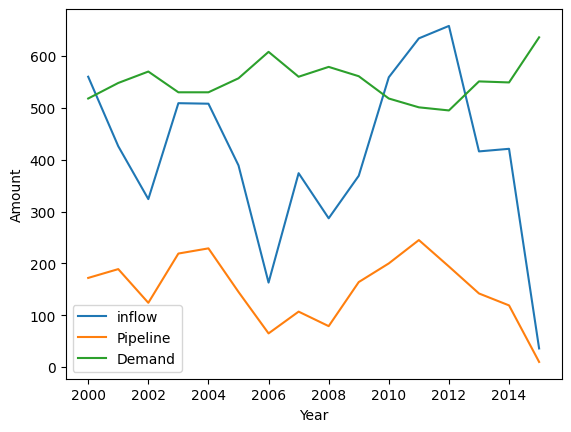

In [14]:
# Plot net inflows, pipeline availability, demand
inflow = data['Inflow']
pip = data['Pipeline']
dmd = data['Demand']
year = data.index

plt.plot(year, inflow, label = "inflow")
plt.plot(year, pip, label = "Pipeline")
plt.plot(year, dmd, label = "Demand")

plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()

# Compare net inflows and demand if Melbourne had infinite water storage



Your answer to part A:
If Melbourne had infinite water storage available, they are not able to supply all their demand from local water.

*Part B:* The provided code includes only local water and reservoir storage. It assumes that the reservoir capacity is 1812 MCM, the starting reservoir storage level at the beginning of the year 2000 is 1148 MCM, and that all demand is supplied each year as long as the storage volume does not go below a minimum storage threshold of 580 MCM. Run the model, calculate: (1) the total unmet water demand from 2000 to 2015, and (2) the maximum volume of unmet demand in any year between 2000 and 2015.

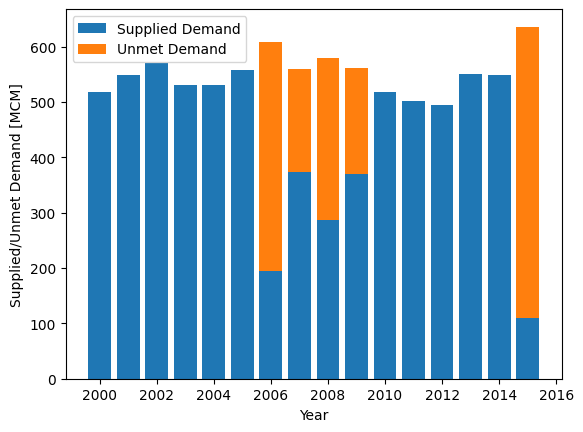

The total unmet demand equals 1610.0
The maximum unmet demand equals 526.0


In [15]:
# Define Constants
reservoirCapacity = 1812 # MCM
initialStorage = 1148 # MCM

# %% Simulate system

# Initialize state variables: storage and met demand
storage = np.zeros(len(data))
demandMet = np.zeros_like(storage)

# Define operating rules
thresh_storage = 580

# Loop over time range
for i in range(len(storage)):

    # Get starting storage level
    if i == 0:
        storage[i] = initialStorage
    else:
        storage[i] = storage[i-1]

    # Add net inflows to storage
    storage[i] = storage[i] + data['Inflow'].iloc[i]

    # Meet as much demand as possible, without going below min level
    storageAvail = np.max([storage[i] - thresh_storage, 0])
    storageUsed = np.min([data['Demand'].iloc[i], storageAvail])
    demandMet[i] = storageUsed
    storage[i] = storage[i] - storageUsed

# Plot met and unmet demand in stacked bar chart
demandUnmet = data['Demand'] - demandMet
plt.figure()
plt.bar(data.index, demandMet, label='Supplied Demand')
plt.bar(data.index, demandUnmet, label='Unmet Demand', bottom=demandMet)
plt.xlabel('Year')
plt.ylabel('Supplied/Unmet Demand [MCM]')
plt.legend()
plt.show()

# Part B - 1
# Calculate unmet demand
total_unmet = np.sum(demandUnmet)
print("The total unmet demand equals", total_unmet)
# Part B - 2
# Determine maximum volume of unmet demand
max_unmet = np.max(demandUnmet)
print("The maximum unmet demand equals", max_unmet)

*Part C:* Now we will build a more comprehensive reservoir system model.

Define a function called "simulate_Melbourne". A good starting point for this function is to use the code provided in Part B.

We will add imported pipeline water and desalinated water to the model. The capacity of the desalination plant is 150 MCM and the cost to produce desalinated water is $0.45/m^3. The water available to import from the pipeline varies by year as indicated in the "pipeline" column of the imported data. Model the operating rules as follows for each year:

*   Inflows enter the reservoir
*   If storage is below the pipeline threshold (1200 MCM), import water from the pipeline and update storage
*   If storage is below the desalination threshold (900 MCM), import water from the desalination plant and update storage
*   Use water in storage to supply demand, but do not let the storage drop below the minimum storage level (580 MCM)

This is illustrated in the schematic below:

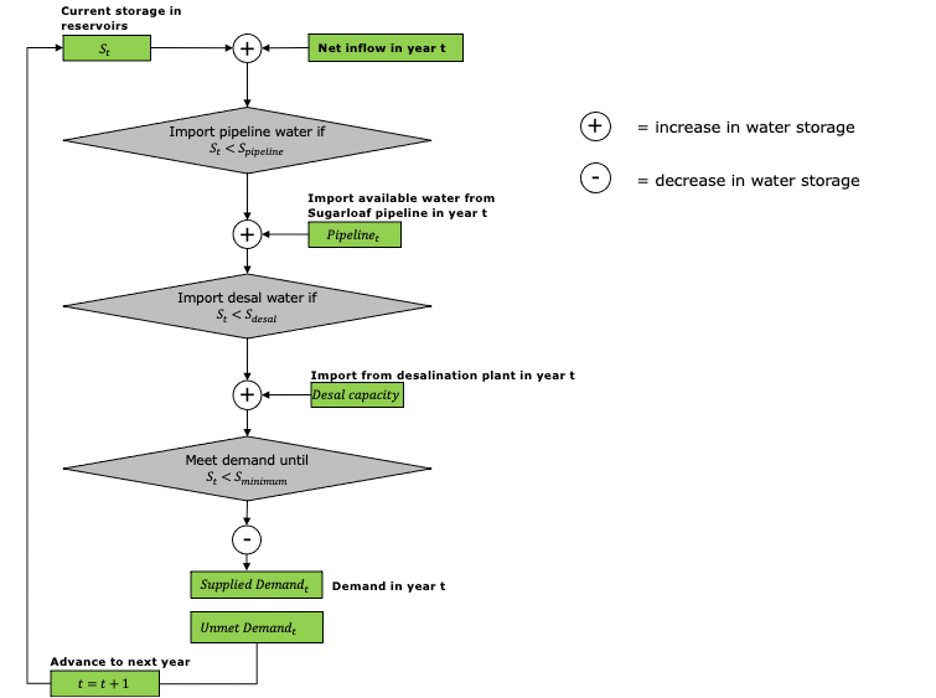

In [16]:
import numpy as np

# Define Constants
desalCapacity = 150  # MCM (million cubic meters)
desalCost = 0.45  # $ per cubic meter
pipelineCost = 0.28  # $ per cubic meter

# Define simulate_Melbourne function
def simulate_Melbourne(inflow, pip, dmd, reservoirCapacity=1812, initialStorage=1148):
    thresh_storage = 580
    storage = np.zeros(len(inflow))
    demandMet = np.zeros(len(inflow))  # Initialize demandMet to store results

    # Loop over time range
    for i in range(len(storage)):

        # Get starting storage level
        if i == 0:
            storage[i] = initialStorage
        else:
            storage[i] = storage[i-1]

        # Add net inflows to storage using pandas indexing with .iloc[]
        storage[i] = storage[i] + inflow.iloc[i]

        # Use pipeline if storage is below 1200 MCM
        if storage[i] < 1200:
            if storage[i] + pip.iloc[i] <= reservoirCapacity:
                storage[i] = storage[i] + pip.iloc[i]
            else:
                storage[i] = reservoirCapacity

        # Use desalination if storage is below 900 MCM
        if storage[i] < 900:
            if storage[i] + desalCapacity <= reservoirCapacity:
                storage[i] = storage[i] + desalCapacity
            else:
                storage[i] = reservoirCapacity

        # Meet as much demand as possible without going below threshold level
        storageAvail = np.max([storage[i] - thresh_storage, 0])
        storageUsed = np.min([dmd.iloc[i], storageAvail])  # Fix this to use the minimum correctly
        demandMet[i] = storageUsed
        storage[i] = storage[i] - storageUsed

    # Calculate unmet demand
    demandUnmet = dmd.values - demandMet  # Ensure demandUnmet is a NumPy array
    return demandUnmet, demandMet, storage


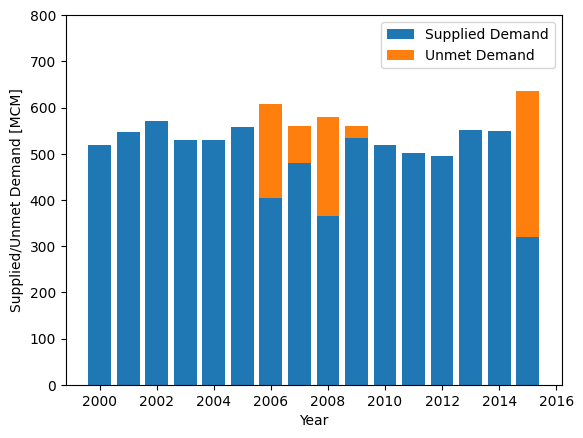

In [17]:
# run simulate_melbourne model

demandUnmet, demandMet, storage = simulate_Melbourne(inflow, pip, dmd)
plt.figure()
plt.bar(data.index, demandMet, label='Supplied Demand')
plt.bar(data.index, demandUnmet, label='Unmet Demand', bottom=demandMet)
plt.ylim(0,800)
plt.xlabel('Year')
plt.ylabel('Supplied/Unmet Demand [MCM]')
plt.legend()
plt.show()

*Part D:* Calculate the change in storage in each year, and write a verification test to check that the water balance is closed in each time period.

In [18]:
# Calculate change in storage
change = np.zeros(len(storage) - 1)
for i in range(len(storage) - 1):
  if i == 0:
    change[i] = storage[i] - initialStorage
  else:
    change[i] = storage[i] - storage[i-1]
print("The change in storage in each year is", change)

#verification
def simulate_Melbourne_with_balance_check(inflow, pip, dmd, reservoirCapacity=1812, initialStorage=1148):
    thresh_storage = 580
    desalCapacity = 150

    storage = np.zeros(len(inflow))
    demandMet = np.zeros(len(inflow))
    desal_used = np.zeros(len(inflow))
    pipeline_used = np.zeros(len(inflow))
    inflow_used = np.zeros(len(inflow))

    # Loop over time range
    for i in range(len(storage)):


      # Get starting storage level
      if i == 0:
        storage[i] = initialStorage
      else:
        storage[i] = storage[i-1]

      # Add net inflows to storage
      if storage[i] + inflow.iloc[i] <= reservoirCapacity:
        storage[i] = storage[i] + inflow.iloc[i]
        inflow_used[i] = inflow.iloc[i]
      else:
        storage[i] = reservoirCapacity
        inflow_used[i] = reservoirCapacity - storage[i]

      if storage[i] < 1200:
        if storage[i] + pip.iloc[i] <= reservoirCapacity:
          storage[i] = storage[i] + pip.iloc[i]
          pipeline_used[i] = pip.iloc[i]
        else:
          pipeline_used[i] = reservoirCapacity - storage[i]
          storage[i] = reservoirCapacity

      if storage[i] < 900:
        if storage[i] + desalCapacity <= reservoirCapacity:
          storage[i] = storage[i] + desalCapacity
          desal_used[i] = desalCapacity

      storageAvail = np.max([storage[i] - thresh_storage, 0])
      storageUsed = np.min([dmd.iloc[i], storageAvail])
      demandMet[i] = storageUsed
      storage[i] = storage[i] - storageUsed

    # Calculate unmet demand
    demandUnmet = dmd.values - demandMet

    # Water balance verification
    total_inflow = np.sum(inflow) + np.sum(pipeline_used) + np.sum(desal_used)
    total_outflow = np.sum(demandMet)
    net_change_in_storage = storage[-1] - initialStorage

    water_balance = total_inflow - total_outflow - net_change_in_storage

    if np.isclose(water_balance, 0):
        print("Water balance is maintained.")
    else:
        print(f"Water balance is NOT zero!")

    return demandUnmet, demandMet, pipeline_used, desal_used, inflow_used, storage

demandUnmet, demandMet, pipeline_used, desal_used, inflow_used, storage = simulate_Melbourne_with_balance_check(inflow, pip, dmd, reservoirCapacity=1812, initialStorage=1148)
# print("storage", storage)
# print("pipeline", pipeline_used)
# print("desal", desal_used)
# print("inflow", inflow_used)


The change in storage in each year is [  42. -122. -246.  -21.  -22.  -23. -176.    0.    0.    0.  241.  133.
  163. -135. -128.]
Water balance is maintained.


*Part E*: Using your updated model, make a stacked bar plot of supplied demand and unmet demand for each year (this code is provided in part B) and a stacked bar plot of the water supplied by source (i.e. inflows, desalination, pipeline) for each year. Calculate and report three performance objectives:

1.   the total sum of unmet demand between 2000 and 2015
2.   the maximum volume of unmet demand in any year between 2000 and 2015
3.   the cost of supplying water

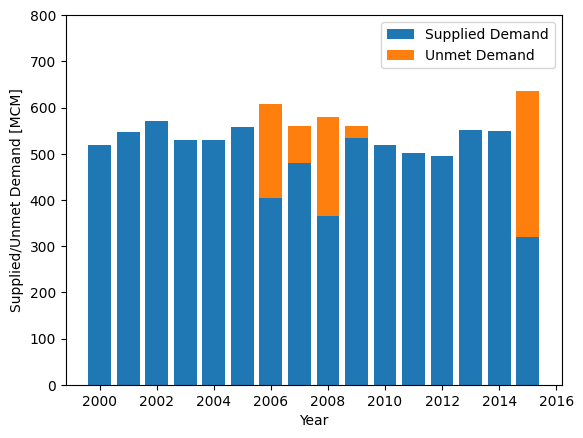

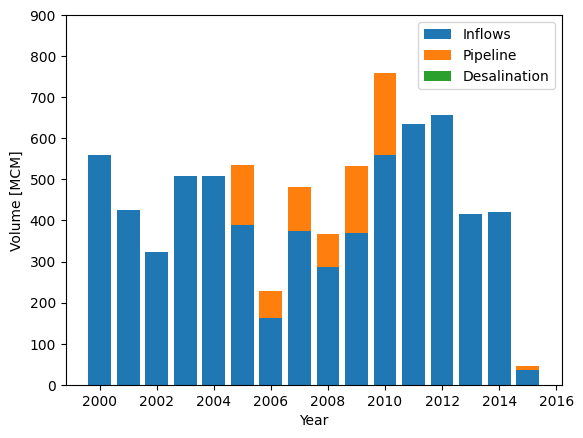

In [19]:
# Create stacked bar plot
plt.figure()
plt.bar(data.index, demandMet, label='Supplied Demand')
plt.bar(data.index, demandUnmet, label='Unmet Demand', bottom=demandMet)
plt.ylim(0,800)
plt.xlabel('Year')
plt.ylabel('Supplied/Unmet Demand [MCM]')
plt.legend()
plt.show()

plt.figure()
plt.bar(data.index, inflow_used, label="Inflows")
plt.bar(data.index, pipeline_used, label="Pipeline", bottom=inflow_used)
plt.bar(data.index, desal_used, label="Desalination", bottom=inflow_used + pipeline_used)

plt.ylim(0,900)
plt.xlabel('Year')
plt.ylabel('Volume [MCM]')
plt.legend()
plt.show()


In [20]:
# Calculate performance objectives -- functionalize it for later use
sum_udmd = np.sum(demandUnmet)
print("The total sum of unmet demand between 2000 and 2015:", sum_udmd)

max_udmd = np.max(demandUnmet)
print("The maximum volume of unmet demand in any year between 2000 and 2015", max_udmd)

desalCost = 0.45  # $ per cubic meter
pipelineCost = 0.28  # $ per cubic meter
cost_pip = pipelineCost * np.sum(pipeline_used) * (10 ** 6)
print("The cost of supplying water", cost_pip)

The total sum of unmet demand between 2000 and 2015: 840.0
The maximum volume of unmet demand in any year between 2000 and 2015 316.0
The cost of supplying water 215600000.00000003


*Part F:* All of the above analysis assumed the use of three operating rules: the storage threshold for importing pipeline water, the storage threshold for importing desalination water, and the minimum storage level. Now, change the thresholds for importing pipeline water and for importing desalination water as follows and run the scenarios for alternative operating policies.

Scenario  | Pipeline Threshold (MCM)  | Desal Threshold (MCM)
----------|---------------------------|---------------------
A | 1000 | 1000
B | 1100 |  900
C | 1200 | 1200
D | 1200 |  900

Report the objective values for the three objectives listed in Part E for each scenario. Are any of the operating policies Pareto dominated? Which objectives show the greatest tradeoffs across operating policies?

In [21]:
# Run each scenario using the simulate_Melbourne function
def simulate_Melbourne_E(pip_thred, desal_thred, inflow, pip, dmd, reservoirCapacity=1812, initialStorage=1148):
    thresh_storage = 580
    desalCapacity = 150

    storage = np.zeros(len(inflow))
    demandMet = np.zeros(len(inflow))
    desal_used = np.zeros(len(inflow))
    pipeline_used = np.zeros(len(inflow))
    inflow_used = np.zeros(len(inflow))

    # Loop over time range
    for i in range(len(storage)):


      # Get starting storage level
      if i == 0:
        storage[i] = initialStorage
      else:
        storage[i] = storage[i-1]

      # Add net inflows to storage
      if storage[i] + inflow.iloc[i] <= reservoirCapacity:
        storage[i] = storage[i] + inflow.iloc[i]
        inflow_used[i] = inflow.iloc[i]
      else:
        storage[i] = reservoirCapacity
        inflow_used[i] = reservoirCapacity - storage[i]

      if storage[i] < pip_thred:
        if storage[i] + pip.iloc[i] <= reservoirCapacity:
          storage[i] = storage[i] + pip.iloc[i]
          pipeline_used[i] = pip.iloc[i]
        else:
          pipeline_used[i] = reservoirCapacity - storage[i]
          storage[i] = reservoirCapacity

      if storage[i] < desal_thred:
        if storage[i] + desalCapacity <= reservoirCapacity:
          storage[i] = storage[i] + desalCapacity
          desal_used[i] = desalCapacity

      storageAvail = np.max([storage[i] - thresh_storage, 0])
      storageUsed = np.min([dmd.iloc[i], storageAvail])
      demandMet[i] = storageUsed
      storage[i] = storage[i] - storageUsed

    # Calculate unmet demand
    demandUnmet = dmd.values - demandMet

    # Water balance verification
    total_inflow = np.sum(inflow) + np.sum(pipeline_used) + np.sum(desal_used)
    total_outflow = np.sum(demandMet)
    net_change_in_storage = storage[-1] - initialStorage

    water_balance = total_inflow - total_outflow - net_change_in_storage

    if np.isclose(water_balance, 0):
        print("Water balance is maintained.")
    else:
        print(f"Water balance is NOT zero!")

    sum_dmd = np.sum(demandUnmet)
    max_dmd = np.max(demandUnmet)


    desalCost = 0.45  # $ per cubic meter
    pipelineCost = 0.28  # $ per cubic meter
    cost = pipelineCost * np.sum(pipeline_used) * (10 ** 6) + desalCost * np.sum(desal_used) * (10 ** 6)

    return sum_dmd, max_dmd, cost


# scenario A
sum_dmdA, max_dmdA, costA = simulate_Melbourne_E(1000, 1000, inflow, pip, dmd, reservoirCapacity=1812, initialStorage=1148)
print(f"For scenario A: The total sum of unmet demand:{sum_dmdA}, The maximum volume of unmet demand:{max_dmdA}, The cost of supplying water: {costA}")

# scenario B
sum_dmdB, max_dmdB, costB = simulate_Melbourne_E(1100, 900, inflow, pip, dmd, reservoirCapacity=1812, initialStorage=1148)
print(f"For scenario B: The total sum of unmet demand:{sum_dmdB}, The maximum volume of unmet demand:{max_dmdB}, The cost of supplying water: {costB}")

# scenario C
sum_dmdC, max_dmdC, costC = simulate_Melbourne_E(1200, 1200, inflow, pip, dmd, reservoirCapacity=1812, initialStorage=1148)
print(f"For scenario C: The total sum of unmet demand:{sum_dmdC}, The maximum volume of unmet demand:{max_dmdC}, The cost of supplying water: {costC}")

# scenario D
sum_dmdD, max_dmdD, costD = simulate_Melbourne_E(1200, 900, inflow, pip, dmd, reservoirCapacity=1812, initialStorage=1148)
print(f"For scenario D: The total sum of unmet demand:{sum_dmdD}, The maximum volume of unmet demand:{max_dmdD}, The cost of supplying water: {costD}")


# Report the results

Water balance is maintained.
For scenario A: The total sum of unmet demand:735.0, The maximum volume of unmet demand:366.0, The cost of supplying water: 321500000.0
Water balance is maintained.
For scenario B: The total sum of unmet demand:885.0, The maximum volume of unmet demand:366.0, The cost of supplying water: 254000000.0
Water balance is maintained.
For scenario C: The total sum of unmet demand:290.0, The maximum volume of unmet demand:236.0, The cost of supplying water: 497100000.0
Water balance is maintained.
For scenario D: The total sum of unmet demand:840.0, The maximum volume of unmet demand:316.0, The cost of supplying water: 215600000.00000003


Scenario B is dominanted by Scenario D since all objective for Scenario D are better: lower total undemand, lower maxima undemand and lower cost. Total sum unmet demand and cost of supplying shows greatest tradeoffs.

*Part G:* Notice that the maximum storage capacity, 1812 MCM, is provided as a parameter in the code but not used in the simulation. Is this a problem? Why or why not? Under what conditions would it be a problem, and how would you address it if so?

For this scenario, it is not a problem because the reservoir capacity is much larger than the combined volumes of demand, inflow, pipeline, and desalination supply. However, if the capacity were significantly smaller, the reservoir could end up holding more water than is physically possible. This would become an issue, especially in wet years when inflows are high or additional water sources are introduced, as it could result in overflow or unrealistic storage levels.

Check Storage After Each Addition: After adding inflows, pipeline water, or desalination water to the storage, ensure that the storage does not exceed the reservoir capacity.

Spill the Excess Water: If the storage exceeds the maximum capacity, the excess water should be considered as "spilled" (i.e., lost), and the storage should be set to the maximum capacity. This spilled water should also be tracked to account for how much water the reservoir cannot hold during high inflow periods.

*Part H:* One conceptual model design choice we made was to lump all of Melbourne's reservoir storage from multiple reservoirs into a single storage variable in our model. Under what conditions would this assumption lead to poor model performance?

Unevern inflow, spatial demand and different capacity of reserviors all can lead to poor model performance. What's more, the different operational rules for different reserviors all influence the model's performance.

And that's Problem 2!

To turn in your assignment:

*   Click the "Share" button in the top right corner of the file. Add the three members of the teaching team as **viewers**, and **uncheck** the "Notify People" option. Click Share.
*   Go back to the "Share" button and copy the link to your file. Paste the link in the text box below. This allows the teaching team to access the original code file if needed.
*   Please save your Google Colab notebook as a PDF by following the exporting instructions posted on Canvas. Next, hand in your assignment by uploading your pdf to Gradescope.

And that's the end of Assignment 3!